In [304]:
import numpy as np
import pandas as pd
from scipy import sparse

from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tag import pos_tag
from nltk.tokenize import word_tokenize

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, TraceMeanField_ELBO
from pyro.optim import Adam, ClippedAdam

In [305]:
# DATA_SRC = './styletopicmodeling/data/enron/users_data_50_unique_clean_min_10_fixed_sender.tsv'

BATCH_SIZE = 512
NUM_WORKERS = 2 #8

LR = 1e-2
BETAS = (0.99, 0.999)
EPS   = 1e-8
CLIP_NORM = 10.
ADAM_ARGS = {'lr': LR, 'betas': BETAS, 'eps': EPS, 'clip_norm': CLIP_NORM}

DEVICE = torch.device('cuda:0')

# Data Setup 

## Data Reading 

In [306]:
import json

DATA_SRC = '/burg/nlp/users/zfh2000/enron_processed.json'
SPLITS_PATH = '/burg/home/zfh2000/styletopicmodeling/scripts/authors_splits.json'
SYNTHETIC_SRC = '/burg/nlp/users/zfh2000/gpt_4_enron_processed.json'

# NICK: files have been uploaded here: https://drive.google.com/drive/folders/1uF9GWEGe4aqSeo2MlachAWR9bTHsJq1q?usp=sharing

with open(DATA_SRC, 'r') as in_file:
    data = json.load(in_file)

with open(SYNTHETIC_SRC, 'r') as in_file:
   synthetic_data = json.load(in_file)

data = data + synthetic_data

with open(SPLITS_PATH, 'r') as in_file:
    SPLITS = json.load(in_file)
    

In [307]:
# data = pd.read_csv(DATA_SRC, sep = '\t', header = None)
# data.columns = ['author', 'text', 'from', 'to', 'cc', 'bcc', 'meta']

In [308]:
def clean_up_features(x):
    # emotion:
    if 'unknown' not in x['emotion']:
        if sum(x['emotion'].values()) == 0:
            x['emotion']['unknown'] = 1
        else:
            x['emotion']['unknown'] = 0

    # morph
    x['morph_tags'] = {k:v for k,v in x['gram2vec'].items() if k.startswith('morph')}
    x['punc_tags'] = {k:v for k,v in x['gram2vec'].items() if k.startswith('punctuation')}
    x['sentences'] = {k:v for k,v in x['gram2vec'].items() if k.startswith('sentences')}
    
    if 'none' not in x['punc_tags']:
        if sum(x['punc_tags'].values()) == 0:
            x['punc_tags']['none'] = 1
        else:
            x['punc_tags']['none'] = 0

    if 'none' not in x['sentences']:
        if sum(x['sentences'].values()) == 0:
            x['sentences']['none'] = 1
        else:
            x['sentences']['none'] = 0
            
        
    

In [309]:
# data.head(2)
for x in data:
    clean_up_features(x)


In [310]:
def fix_normalization(x):
    # print(x)
    replaced = np.where(x==0, 1, x)
    minimum = np.min(replaced)
    if minimum < 1:
        # print(minimum)
        scale = 1/minimum
        x = (x*scale).astype(int)
    # print(x)
    return x


def extract_features(doc, meta_feature_to_names):
    features = {'text':doc['text']}
    for key, possible in meta_feature_to_names.items():
        if isinstance(doc[key], list):
            features[key] = np.array([doc[key].count(l) for l in possible])
            # features[key] = features[key] #/ np.sum(features[key])
        elif isinstance(doc[key], dict):
            features[key] = np.array([doc[key][l] for l in possible]).astype(float)
            # features[key] = features[key] #/ np.sum(features[key])
        else:
            raise NotImplementedError()

        features[key] = fix_normalization(features[key])

         

        

        # features[key] = np.nan_to_num(features[key], nan=1/len(features[key]))

    return features


                        
            
print(fix_normalization(np.array([1,0,4,6])))
print(fix_normalization(np.array([0,0,0.9,0.1])))
print(fix_normalization(np.array([0,0,1,0])))

[1 0 4 6]
[0 0 9 1]
[0 0 1 0]


In [311]:
def get_possible_values(data, key):
    if isinstance(data[0][key], dict):
        return sorted(data[0][key].keys())
    else:
        values = []
        for d in data:
            values.extend(d[key])
        return sorted(set(values))
    
            
            
        
data[1]

{'text': 'test successful. way to go!!!',
 'info': {'author': 'allen-p',
  'from': 'From: phillip.allen@enron.com',
  'to': 'X-To: Leah Van Arsdall',
  'cc': 'X-cc:',
  'bcc': 'X-bcc:',
  'meta': 'Date: Wed, 18 Oct 2000 03:00:00 -0700 (PDT)'},
 'sentences': {'sentences:it-cleft': 0.0,
  'sentences:pseudo-cleft': 0.0,
  'sentences:all-cleft': 0.0,
  'sentences:there-cleft': 0.0,
  'sentences:if-because-cleft': 0.0,
  'sentences:passive': 0.0,
  'sentences:subj-relcl': 0.0,
  'sentences:obj-relcl': 0.0,
  'sentences:tag-question': 0.0,
  'sentences:coordinate-clause': 0.0,
  'none': 1},
 'passive': [0, 0],
 'formality': ['Formal', 'Informal'],
 'pos': {'ADJ': 1,
  'ADP': 0,
  'ADV': 0,
  'CONJ': 0,
  'DET': 0,
  'NOUN': 2,
  'NUM': 0,
  'PRT': 1,
  'PRON': 0,
  'VERB': 1,
  '.': 4,
  'X': 0},
 'question': ['statement', 'statement'],
 'gram2vec': {'pos_unigrams:ADJ': 0.1111111111111111,
  'pos_unigrams:ADP': 0.0,
  'pos_unigrams:ADV': 0.0,
  'pos_unigrams:AUX': 0.0,
  'pos_unigrams:CCONJ'

In [312]:
meta_feature_to_names = {}
#  'sentences',
#  'irony_task'
# 'punc_tags' < need to unnormalize
# 'morph_tags' < need to unnormalize


# for key in ['formality', 'punc_tags', 'morph_tags', 'pos', 'casing', 'question',  'passive', 'emotion_task', 'sentiment_task', 'emoji_task']:
# for key in ['formality', 'punc_tags', 'pos', 'casing', 'emoji_task']:

# NICK: Unsure which of of these features we should include!
for key in ['formality', 'casing', 'emoji_task']:
    meta_feature_to_names[key] = get_possible_values(data, key)
    

extracted_features = [extract_features(d, meta_feature_to_names) for d in data]

extracted_features[2]

{'text': 'Randy, Can you send me a schedule of the salary and level of everyone in the scheduling group. Plus your thoughts on any changes that need to be made. (Patti S for example) Phillip',
 'formality': array([4, 0]),
 'casing': array([0, 4, 0]),
 'emoji_task': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])}

## Data Processing 

### BOW 

In [313]:
vectorizer = CountVectorizer(max_df=0.5, min_df=5, stop_words='english')
vectorizer.fit([d['text'] for d in extracted_features])

training = []
holdout = []

authors = [d['info']['from'] for d in data]
for author, d  in zip(authors, extracted_features):
    if author.startswith('gpt') or author in SPLITS['train']:
        training.append(d)

    else:
        holdout.append(d)
        assert author in SPLITS['test']
        
bows = {}
meta_vectorized = {}

for split_name, data_split in zip(['training','holdout'], [training, holdout]):
     bows[split_name] = vectorizer.transform([d['text'] for d in data_split])
     meta_vectorized[split_name] = {}
     for key in tqdm(sorted(data_split[0].keys())):
        if key == 'text': continue
        meta_vectorized[split_name][key] = sparse.csr_matrix(np.stack([d[key] for d in data_split]))
        assert(bows[split_name].shape[0] == meta_vectorized[split_name][key].shape[0])
    
    




100%|████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 80.79it/s]


### Bag-of-POS 

In [314]:
# uni_tags = ['ADJ', 'ADP', 'ADV', 'CONJ', 'DET', 'NOUN', 'NUM', 'PRT', 'PRON', 'VERB', '.', 'X']

In [315]:
# def get_pos_rep(text, tagset):
#     emb = {tag: 0 for tag in uni_tags}
#     tags = [tag[1] for tag in pos_tag(word_tokenize(test_txt), tagset = 'universal')]
#     for tag in tags:
#         emb[tag] += 1
#     return list(emb.values())

In [316]:
# bops = data['text'].progress_apply(lambda txt: get_pos_rep(txt, uni_tags)).tolist()

In [317]:
# bops = sparse.csr_matrix(bops)

### Summary 

In [318]:
NUM_DOCS   = bows['training'].shape[0]
VOCAB_SIZE = bows['training'].shape[1]
META_SIZE  = {k:v.shape[1] for k,v in meta_vectorized['training'].items()}

In [319]:
print(f'BOW Dims: {bows["training"].shape}')
print(f'META Dims: {META_SIZE}')

BOW Dims: (66668, 9267)
META Dims: {'casing': 3, 'emoji_task': 20, 'formality': 2}


## Dataset

In [320]:
class DocMetaData(Dataset):
    
    def __init__(self, bows, metas, dtype = np.float32):
        self.bows = bows
        self.metas = metas
        
        self.dtype = dtype
        
    def __len__(self):
        return self.bows.shape[0]
    
    def __getitem__(self, idx):
        
        bow = self.bows[idx].toarray().astype(self.dtype)[0]
        
        meta = {key:self.metas[key][idx].toarray().astype(self.dtype)[0] for key in self.metas}
        
        batch = {
            'bow': bow,
            'meta': meta,
        }
        
        return batch

In [321]:
dataset = DocMetaData(bows['training'], meta_vectorized['training'])
eval_dataset = DocMetaData(bows['training'], meta_vectorized['training'])

In [322]:
dl = DataLoader(dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)
eval_dl = DataLoader(eval_dataset, batch_size = BATCH_SIZE, num_workers = NUM_WORKERS, shuffle=True)

In [323]:
test_ = next(iter(dl))
for k, v in test_.items():
    print(k, v)
    # print(f'{k:7s}: {str(v.shape):25s} {str(v.dtype):25s}')

bow tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
meta {'casing': tensor([[0., 2., 0.],
        [1., 2., 0.],
        [1., 2., 0.],
        ...,
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.]]), 'emoji_task': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]]), 'formality': tensor([[1., 1.],
        [2., 1.],
        [2., 1.],
        ...,
        [1., 0.],
        [0., 1.],
        [1., 0.]])}


# Model Definition 

## Neural Layers 

In [324]:
# class Encoder(nn.Module):
#     # Base class for the encoder net, used in the guide
#     def __init__(self, vocab_size, num_topics, hidden, dropout, eps = 1e-10):
#         super().__init__()
        
#         self.eps = eps
        
#         self.drop = nn.Dropout(dropout)  # to avoid component collapse
#         self.fc1 = nn.Linear(vocab_size, hidden)
#         self.fc2 = nn.Linear(hidden, hidden)
#         self.fcmu = nn.Linear(hidden, num_topics)
#         self.fclv = nn.Linear(hidden, num_topics)

#         self.bnmu = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse
#         self.bnlv = nn.BatchNorm1d(num_topics, affine=False)  # to avoid component collapse

#     def forward(self, inputs):
#         h = F.softplus(self.fc1(inputs))
#         h = F.softplus(self.fc2(h))
#         h = self.drop(h)
#         # μ and Σ are the outputs
#         logtheta_loc = self.bnmu(self.fcmu(h))
#         logtheta_logvar = self.bnlv(self.fclv(h))
#         logtheta_scale = self.eps + (0.5 * logtheta_logvar).exp()  # Enforces positivity
#         return logtheta_loc, logtheta_scale
    
# class MetaDocEncoder(nn.Module):
    
#     def __init__(self, vocab_size, meta_size, num_styles, hidden, dropout, eps = 1e-10):
#         super().__init__()
        
#         self.eps = eps
        
#         self.drop = nn.Dropout(dropout)  # to avoid component collapse
#         self.fc1_doc = nn.Linear(vocab_size, hidden)
#         self.fc1_meta = nn.Linear(meta_size, hidden)
#         self.fc2 = nn.Linear(2 * hidden, hidden)
#         self.fcmu = nn.Linear(hidden, num_styles)
#         self.fclv = nn.Linear(hidden, num_styles)

#         self.bnmu = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse
#         self.bnlv = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse

#     def forward(self, inputs_doc, inputs_meta):
#         h_doc = F.softplus(self.fc1_doc(inputs_doc))
#         h_meta = F.softplus(self.fc1_meta(inputs_meta))
#         h = torch.hstack([h_doc, h_meta])
#         h = F.softplus(self.fc2(h))
#         h = self.drop(h)
#         # μ and Σ are the outputs
#         logkappa_loc = self.bnmu(self.fcmu(h))
#         logkappa_logvar = self.bnlv(self.fclv(h))
#         logkappa_scale = self.eps + (0.5 * logtheta_logvar).exp()  # Enforces positivity
#         return logkappa_loc, logkappa_scale


class GeneralEncoder(nn.Module):
    
    def __init__(self, size_dict, num_styles, hidden, dropout, eps = 1e-10):
        super().__init__()
        
        self.eps = eps

        self.sizes = size_dict
        
        self.drop = nn.Dropout(dropout)  # to avoid component collapse
        
        # self.fc1_doc = nn.Linear(vocab_size, hidden)
        # self.fc1_meta = nn.Linear(meta_size, hidden)

        self.features = sorted(size_dict.keys())
        self.fc1s = nn.ModuleDict({feature:nn.Linear(self.sizes[feature], hidden) for feature in self.features})
        self.fc2 = nn.Linear(len(self.features) * hidden, hidden)
        self.fcmu = nn.Linear(hidden, num_styles)
        self.fclv = nn.Linear(hidden, num_styles)

        self.bnmu = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse
        self.bnlv = nn.BatchNorm1d(num_styles, affine=False)  # to avoid component collapse

    def forward(self, inputs): #inputs_doc, inputs_meta):
        assert isinstance(inputs, dict)
        first_hiddens = []
        for _, feature in enumerate(self.features):
            first_hiddens.append(F.softplus(self.fc1s[feature](inputs[feature])))
        
        h = torch.hstack(first_hiddens)
        h = F.softplus(self.fc2(h))
        h = self.drop(h)
        # μ and Σ are the outputs
        logkappa_loc = self.bnmu(self.fcmu(h))
        logkappa_logvar = self.bnlv(self.fclv(h))
        logkappa_scale = self.eps + (0.5 * logkappa_logvar).exp()  # Enforces positivity
        return logkappa_loc, logkappa_scale

In [325]:
class Decoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, dropout):
        super().__init__()
        self.beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs):
        inputs = self.drop(inputs)
        # the output is σ(βθ)
        return self.bn(self.beta(inputs))
    
class MetaDocDecoder(nn.Module):
    # Base class for the decoder net, used in the model
    def __init__(self, vocab_size, num_topics, num_styles, dropout):
        super().__init__()
        self.t_beta = nn.Linear(num_topics, vocab_size, bias=False)
        self.s_beta = nn.Linear(num_styles, vocab_size, bias=False)
        self.t_bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.s_bn = nn.BatchNorm1d(vocab_size, affine=False)
        self.drop = nn.Dropout(dropout)

    def forward(self, inputs_doc, inputs_meta):
        inputs_doc  = self.drop(inputs_doc)
        inputs_meta = self.drop(inputs_meta)
        # the output is σ(βθ)
        
        dist_t = self.t_bn(self.t_beta(inputs_doc))
        dist_s = self.s_bn(self.s_beta(inputs_meta))
        
        return 0.5 * (dist_t + dist_s)

## ProdSLDA 

In [326]:
class ProdSLDA(nn.Module):
    
    PRIOR_DISTS  = {'gaussian': dist.Normal,
                    'laplace': dist.Laplace,
                   }
    TK_LINKS     = ('none', # Model style and documents independently
                    'kappa_doc', # Allow kappa to effect word distributions
                    'kappa_doc_style', # Allow kappa to effect word distributions and sampled words to effect style
                   )
    
    def __init__(self, vocab_size, meta_sizes, num_topics, num_styles, hidden, dropout, 
                 theta_prior_dist = 'gaussian', theta_prior_loc = 0., theta_prior_scale = 1.,
                 kappa_prior_dist = 'laplace', kappa_prior_loc = 0., kappa_prior_scale = 1.,
                 style_topic_link = 'none',
                 eps = 1e-10):
        super().__init__()
        
        # Global model variables
        self.vocab_size = vocab_size
        self.meta_sizes = meta_sizes
        self.num_topics = num_topics
        self.num_styles = num_styles
        self.hidden     = hidden
        self.dropout    = dropout

        self.meta_features = sorted(self.meta_sizes.keys())
        
        self.eps = eps
        
        # Theta Prior
        if theta_prior_dist not in ProdSLDA.PRIOR_DISTS.keys():
            raise ValueError(f'Theta prior {theta_prior_dist} not yet implemented. Must be one of {", ".join(ProdSLDA.PRIOR_DISTS.keys())}')
        self.theta_prior_dist = theta_prior_dist
        
        self.theta_prior_scale = theta_prior_scale
        self.theta_prior_loc = theta_prior_loc
        
        # Kappa Prior
        if kappa_prior_dist not in ProdSLDA.PRIOR_DISTS.keys():
            raise ValueError(f'Kappa prior {kappa_prior_dist} not yet implemented. Must be one of {", ".join(ProdSLDA.PRIOR_DISTS.keys())}')
        self.kappa_prior_dist = kappa_prior_dist
        
        self.kappa_prior_scale = kappa_prior_scale
        self.kappa_prior_loc = kappa_prior_loc
        
        
        # Document style linking
        self.style_topic_link = style_topic_link
        
        if self.style_topic_link not in ProdSLDA.TK_LINKS:
            raise ValueError(f'Link {self.style_topic_link} not yet implemented. Must be one of {", ".join(ProdSLDA.TK_LINKS)}')
        elif self.style_topic_link == 'none':
            # Independent modeling of style and topic, all normal encoder/decoders
            
            self.encoder = GeneralEncoder({'doc':vocab_size}, num_topics, hidden, dropout, self.eps)
            self.decoder = Decoder(vocab_size, num_topics, dropout)
            self.style_encoder = GeneralEncoder(meta_sizes, num_styles, hidden, dropout, self.eps)
            self.style_decoder = nn.ModuleDict({feature: Decoder(meta_s, num_styles, dropout) for feature, meta_s in meta_sizes.items()})
            
        elif self.style_topic_link == 'kappa_doc':
            # raise NotImplementedError()
            # Doc influences kappa encoding, style encoder takes in doc
            self.encoder = GeneralEncoder({'doc':vocab_size}, num_styles, hidden, dropout, self.eps)
            self.style_encoder = GeneralEncoder({'doc':vocab_size, **meta_sizes}, num_styles, hidden, dropout, self.eps)

            self.decoder = MetaDocDecoder(vocab_size=vocab_size, num_topics=num_topics, num_styles=num_styles, dropout=dropout)
            self.style_decoder = nn.ModuleDict({feature: Decoder(meta_s, num_styles, dropout) for feature, meta_s in meta_sizes.items()})


    def model(self, docs, metas):
        pyro.module("decoder", self.decoder)
        pyro.module("style_decoder", self.style_decoder)
        
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution
            logtheta_loc = docs.new_zeros((docs.shape[0], self.num_topics)) * self.theta_prior_loc
            logtheta_scale = docs.new_ones((docs.shape[0], self.num_topics)) * self.theta_prior_scale
            logkappa_loc = docs.new_zeros((docs.shape[0], self.num_styles)) * self.kappa_prior_loc
            logkappa_scale = docs.new_ones((docs.shape[0], self.num_styles)) * self.kappa_prior_scale
            
            # if self.style_topic_link == 'kappa_doc':
                # logtheta_s_loc = docs.new_zeros((docs.shape[0], self.num_topics)) * self.theta_prior_loc
                # logtheta_s_scale = docs.new_ones((docs.shape[0], self.num_topics)) * self.theta_prior_scale
                
                # logtheta_s = pyro.sample(
                    # "logtheta_s", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_s_loc, logtheta_s_scale).to_event(1))
                
                # theta_s = F.softmax(logtheta_s, -1)
            
            logtheta = pyro.sample(
                "logtheta", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_loc, logtheta_scale).to_event(1))
            logkappa = pyro.sample(
                "logkappa", ProdSLDA.PRIOR_DISTS[self.kappa_prior_dist](logkappa_loc, logkappa_scale).to_event(1))
            
            theta = F.softmax(logtheta, -1)
            kappa = F.softmax(logkappa, -1)

            if self.style_topic_link == 'none':
                word_logits = self.decoder(theta)
            elif self.style_topic_link == 'kappa_doc':
                word_logits = self.decoder(theta, kappa)
                
            style_logits = {feature:self.style_decoder[feature](kappa) for feature in self.meta_features}

            total_count = int(docs.sum(-1).max())
            pyro.sample(
                'obs_doc',
                dist.Multinomial(total_count, logits = word_logits),
                obs=docs
            )

            for feature in self.meta_features:
                total_s_count = int(metas[feature].sum(-1).max())
                pyro.sample(
                    'obs_meta_'+feature,
                    dist.Multinomial(total_s_count, logits = style_logits[feature]),
                    obs=metas[feature]
                )

    def guide(self, docs, metas):
        pyro.module("encoder", self.encoder)
        pyro.module("style_encoder", self.encoder)
            
        with pyro.plate("documents", docs.shape[0]):
            # Dirichlet prior 𝑝(𝜃|𝛼) is replaced by a logistic-normal distribution,
            # where μ and Σ are the encoder network outputs
            
            if self.style_topic_link == 'none':
                logtheta_loc, logtheta_scale = self.encoder({'doc':docs})
                logkappa_loc, logkappa_scale = self.style_encoder(metas)

            elif self.style_topic_link == 'kappa_doc':
                # raise NotImplementedError()
                # logtheta_loc, logtheta_scale, logkappa_d_loc, logkappa_d_scale = self.encoder({'doc':docs, **metas})
                logtheta_loc, logtheta_scale  = self.encoder({'doc':docs})
                logkappa_loc, logkappa_scale = self.style_encoder({'doc':docs, **metas})

                # NICK what was the point of d_loc and d_scale? Shoudln't we be generating one set of kappas from both features?
                
                # Average theta loc from document and style
                # logkappa_loc = 0.5 * (logkappa_loc + logkappa_d_loc) 
                # logkappa_scale = 0.5 * (logkappa_scale + logkappa_d_scale)
            
            # Sample logtheta/logkappa from guide
            logtheta = pyro.sample(
                "logtheta", ProdSLDA.PRIOR_DISTS[self.theta_prior_dist](logtheta_loc, logtheta_scale).to_event(1))
            logkappa = pyro.sample(
                "logkappa", ProdSLDA.PRIOR_DISTS[self.kappa_prior_dist](logkappa_loc, logkappa_scale).to_event(1))

        return logtheta, logkappa
            

    def beta_document(self):
        if self.style_topic_link == 'none':
            return {'beta_topic':self.decoder.beta.weight.cpu().detach().T}
        elif self.style_topic_link == 'kappa_doc':
            return {
                'beta_topic':self.decoder.t_beta.weight.cpu().detach().T,
                'beta_style':self.decoder.s_beta.weight.cpu().detach().T,
            }
        else:
            raise NotImplementedError()
            
    def beta_meta(self):
        # beta matrix elements are the weights of the FC layer on the decoder
        # return self.decoder.beta.weight.cpu().detach().T
        retval = {}
        for key, layer in self.style_decoder.items():
            retval[key] = layer.beta.weight.cpu().detach().T
        return retval
            
            

# Model Fitting 

## Setup

In [327]:
NUM_TOPICS = 2 #10 #20 # NICK totally subject to changes
NUM_STYLES = 5 #20
HIDDEN_DIM = 64
DROPOUT    = 0 #0.2

THETA_PRIOR_DIST = 'gaussian'
THETA_PRIOR_LOC = 0.
THETA_PRIOR_SCALE = 1.

KAPPA_PRIOR_DIST = 'gaussian' #'laplace'
KAPPA_PRIOR_LOC = 0.
KAPPA_PRIOR_SCALE = 5 #10 #1.

STYLE_TOPIC_LINK = 'none' #'kappa_doc' #'none'

NUM_EPOCHS = 5 #100

In [328]:
prod_slda = ProdSLDA(
    vocab_size = VOCAB_SIZE,
    meta_sizes  = META_SIZE,
    num_topics = NUM_TOPICS, num_styles = NUM_STYLES, 
    hidden = HIDDEN_DIM, dropout = DROPOUT, 
    theta_prior_dist = THETA_PRIOR_DIST, 
    theta_prior_loc = THETA_PRIOR_LOC, theta_prior_scale = THETA_PRIOR_SCALE,
    kappa_prior_dist = KAPPA_PRIOR_DIST, 
    kappa_prior_loc = KAPPA_PRIOR_LOC, kappa_prior_scale = KAPPA_PRIOR_SCALE,
    style_topic_link = STYLE_TOPIC_LINK,
).to(DEVICE)

print(prod_slda.beta_document())
print(prod_slda.beta_meta())


{'beta_topic': tensor([[ 0.3219, -0.3228,  0.2473,  ...,  0.2530,  0.4218,  0.3623],
        [ 0.6130, -0.4193,  0.2803,  ...,  0.2308, -0.0440,  0.3505]])}
{'casing': tensor([[-0.3513, -0.1330, -0.1180],
        [ 0.3769,  0.3620, -0.2804],
        [ 0.2608,  0.2996,  0.3237],
        [-0.1080, -0.0335,  0.0210],
        [ 0.1613, -0.3005,  0.4137]]), 'emoji_task': tensor([[-0.2523,  0.2563, -0.2395, -0.0471, -0.1673,  0.2004, -0.0693,  0.4118,
          0.4196, -0.2406,  0.1092, -0.1767, -0.0996, -0.4023, -0.0252,  0.3606,
         -0.3093,  0.3609, -0.1606,  0.4234],
        [-0.0951,  0.1032,  0.2689,  0.3702, -0.0755, -0.1163,  0.0347,  0.0747,
         -0.3832,  0.2645,  0.1461,  0.3203,  0.2359, -0.1876, -0.1480,  0.0237,
         -0.0767, -0.0182,  0.2285, -0.3614],
        [ 0.2259,  0.2566, -0.1772,  0.0814,  0.3011, -0.1660,  0.0536,  0.0503,
          0.0225, -0.1134, -0.1785,  0.2309, -0.2858, -0.2297,  0.0615, -0.2114,
         -0.2107, -0.2188,  0.4054, -0.0154],
       

## Training 

In [329]:
pyro.clear_param_store()
prod_slda.train()
print(DEVICE)
_

cuda:0


{'text': 'Randy, Can you send me a schedule of the salary and level of everyone in the scheduling group. Plus your thoughts on any changes that need to be made. (Patti S for example) Phillip',
 'formality': array([4, 0]),
 'casing': array([0, 4, 0]),
 'emoji_task': array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0])}

In [330]:
optim = pyro.optim.ClippedAdam(ADAM_ARGS)

svi = SVI(
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    pyro.poutine.scale(prod_slda.model, BATCH_SIZE/len(dl.dataset)),
    optim,
    loss = TraceMeanField_ELBO()
)

In [331]:
# print(pyro.poutine.trace(prod_slda.model).get_trace(test_['bow'].to(DEVICE), test_['meta'].to(DEVICE)).format_shapes())

In [332]:
print(pyro.poutine.trace(prod_slda.guide).get_trace(test_['bow'].to(DEVICE), {k:v.to(DEVICE) for k,v in test_['meta'].items()}).format_shapes())


                  Trace Shapes:           
                   Param Sites:           
      encoder$$$fc1s.doc.weight  64 9267  
        encoder$$$fc1s.doc.bias       64  
           encoder$$$fc2.weight  64   64  
             encoder$$$fc2.bias       64  
          encoder$$$fcmu.weight   2   64  
            encoder$$$fcmu.bias        2  
          encoder$$$fclv.weight   2   64  
            encoder$$$fclv.bias        2  
style_encoder$$$fc1s.doc.weight  64 9267  
  style_encoder$$$fc1s.doc.bias       64  
     style_encoder$$$fc2.weight  64   64  
       style_encoder$$$fc2.bias       64  
    style_encoder$$$fcmu.weight   2   64  
      style_encoder$$$fcmu.bias        2  
    style_encoder$$$fclv.weight   2   64  
      style_encoder$$$fclv.bias        2  
                  Sample Sites:           
                 documents dist        |  
                          value 512    |  
                  logtheta dist 512    | 2
                          value 512    | 2
           

In [333]:
train_elbo = []
val_elbo = []

print("---TRAINING---")
for epoch in range(NUM_EPOCHS):
    
    epoch_elbo = 0.
    prod_slda.train()
    for batch in tqdm(dl):
        
        bow = batch['bow'].to(DEVICE)
        bop = {k:v.to(DEVICE) for k,v in batch['meta'].items()}
        
        epoch_elbo += svi.step(bow, bop)

    eval_elbo = 0
    prod_slda.eval()
    for batch in tqdm(eval_dl):
        bow = batch['bow'].to(DEVICE)
        bop = {k:v.to(DEVICE) for k,v in batch['meta'].items()}

        # NICK: I think this may still be optimizing on holdout?
        eval_elbo += svi.evaluate_loss(bow, bop)

    
    print(f'Epoch {epoch}: {epoch_elbo:.3f}')
    print(f'Epoch {epoch}: Eval: {eval_elbo:.3f}')
    
    train_elbo.append(epoch_elbo)

---TRAINING---


  0%|                                                                              | 0/131 [00:00<?, ?it/s]/burg/nlp/users/zfh2000/miniconda3/lib/python3.11/site-packages/pyro/util.py:288: UserWarning: Found non-auxiliary vars in guide but not model, consider marking these infer={'is_auxiliary': True}:
{'obs_meta_formality', 'obs_meta_emoji_task', 'obs_doc', 'obs_meta_casing'}
  warnings.warn(
100%|████████████████████████████████████████████████████████████████████| 131/131 [00:22<00:00,  5.70it/s]


Epoch 0: 36589.786
Epoch 0: Eval: 36471.547


100%|████████████████████████████████████████████████████████████████████| 131/131 [00:23<00:00,  5.58it/s]


Epoch 1: 36357.700
Epoch 1: Eval: 36375.898


100%|████████████████████████████████████████████████████████████████████| 131/131 [00:19<00:00,  6.74it/s]


Epoch 2: 36300.900
Epoch 2: Eval: 36315.531


100%|████████████████████████████████████████████████████████████████████| 131/131 [00:19<00:00,  6.70it/s]


Epoch 3: 36278.818
Epoch 3: Eval: 36237.491


100%|████████████████████████████████████████████████████████████████████| 131/131 [00:22<00:00,  5.91it/s]

Epoch 4: 36241.503
Epoch 4: Eval: 36240.070


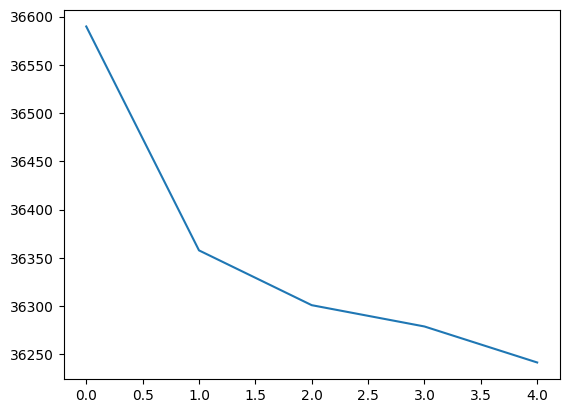

In [334]:
plt.plot(range(len(train_elbo)), train_elbo)

plt.show()

In [335]:
# print(prod_slda.beta_document())
# print(prod_slda.beta_meta())
for key, value in prod_slda.beta_meta().items():
    print(key, F.softmax(value,-1))

casing tensor([[0.4486, 0.2897, 0.2617],
        [0.3345, 0.3537, 0.3119],
        [0.2290, 0.3860, 0.3850],
        [0.4337, 0.2909, 0.2754],
        [0.3363, 0.3339, 0.3298]])
emoji_task tensor([[0.0673, 0.0494, 0.0508, 0.0447, 0.0498, 0.0518, 0.0419, 0.0484, 0.0378,
         0.0407, 0.0735, 0.0607, 0.0365, 0.0345, 0.0418, 0.0506, 0.0514, 0.0509,
         0.0629, 0.0546],
        [0.0785, 0.0343, 0.0427, 0.0459, 0.0526, 0.0514, 0.0358, 0.0559, 0.0486,
         0.0326, 0.0657, 0.0603, 0.0399, 0.0213, 0.0419, 0.0388, 0.0497, 0.0407,
         0.0636, 0.0999],
        [0.0595, 0.0573, 0.0523, 0.0451, 0.0470, 0.0525, 0.0452, 0.0452, 0.0333,
         0.0463, 0.0806, 0.0532, 0.0360, 0.0415, 0.0432, 0.0617, 0.0505, 0.0518,
         0.0560, 0.0420],
        [0.0760, 0.0374, 0.0462, 0.0468, 0.0541, 0.0518, 0.0386, 0.0546, 0.0472,
         0.0348, 0.0690, 0.0633, 0.0414, 0.0208, 0.0427, 0.0415, 0.0494, 0.0436,
         0.0665, 0.0744],
        [0.0385, 0.0890, 0.0546, 0.0360, 0.0369, 0.0462, 0.

In [336]:
path = 'prod_slda_saved_model'
prod_slda.eval()
torch.save(prod_slda, path)

# pyro.clear_param_store()
# prod_slda = torch.load(path)